# Project 5
**Author:** Tommy Phung <br>
**Target:** Video Game Developers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


### Modeling Libraries used 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

### Custom made functions for cleaning data
from functions import data_cleaning as dc 

## Business Understanding 
Video games have been a form of entertainment for all ages around the world. There has been **an increase in game production** with all the access to tools online as well as the demand for these games especially for the last couple of years of quarantine. Every year, **Steam**, one of the largest online video game platforms, has 300 games on average published a day and this has only been increasing in the past decade.  With so many games getting published, there is a risk that the game won't be made profitable. 
Depending on the company size, the number of sales changes can be a sign of a profitable game. <br>

For example, Triple-A games are expected to have a sale of **10 million units** whereas Indie games, which are smaller game companies, would expect **100,000 units** to be successful. 
There is also a bigger budget range when comparing Triple-A companies and Indie companies. 
To make a game that many would be interested in buying, **certain genres are more desirable than others** for the average player. By modeling the genres of the games, we can **isolate the genres to the best** to have when making a game that would **reach the benchmark** mentioned above. 

This information would be useful to have for Indie developers that would sell their games on Steam but can apply to other platforms. If a new developer is attempting to create a game, they should use the information to determine the best type of game that the audience would want to buy. Triple-A companies using the model should look at the worst genres and avoid those since they are already established and could improve their current library of games instead. 

## Data Understanding 
The first dataset came from https://www.backloggd.com/ and Kaggle. Backloggd is a community-based listing website that takes lists of games and combined them with various features such as ratings, played and wishlist. The main feature we looked at is genres with some insight gained from the Ratings feature.

The second dataset contians the sales of games from various regions. I looked at Global Sales which is just the sum of all the columns in the dataset. 

Since I am using both dataset, they need to match with one another to anaysis them fairly. This was the brekadown on the number of games and the final resulting dataframe. 

|  | Backloggd | Ranked | **Final** |
|---|:---:|:---:|:---:|
| **# of Games** | 60,000 | 16,598 | **4,466** |
| **Desired Feature** | Genres | Global Sales | **N/A** |
| **# of Columns** | 12 | 10 | **6** |

## Import Datasets 

In [2]:
df = pd.read_csv('datasets/backloggd_games.csv', index_col= 0)    ### Main dataset with the genres.
ranked_df = pd.read_csv('datasets/vgsales.csv')    ### Dataset to grab global sales from. 
comb_df = df[df.Title.isin(ranked_df.Name.unique())]
comb_df.reset_index(drop= True, inplace = True)

## Data Preperations
To prepare the dataset, I looked for duplicates. There was **no missing values** that would impact the modeling. <br>
Three columns from the two datasets that matter were the **Title, Genres, and Ratings**. <br>
Genres needed to be formatted so that the literal string can be converted to an actual list of genres to manipulate. Since the ranked dataset separates games based on platforms, I grouped the sales and summed the values to a single unique title. 

The last step was to create two different columns to **indicate profitability**. Two metrics to consider was that triple-A title has higher expected sales to be profitable while Indie games have a lower threshold. I determine the threshold being **1 million or 1 in global sales for Triple-A** and **100,000 or .1 for Indie Games.**

#### Extract Useful Columns

In [3]:
comb_df = comb_df[['Title', 'Genres', 'Rating']] 
comb_df.drop_duplicates(subset= 'Title', inplace= True)    ### Drop any duplicates
comb_df.Genres = df.Genres.apply(dc.convert_to_list)   ### Convert to list like

#### Combine Second Dataset Column

In [4]:
matched_df = ranked_df[ranked_df.Name.isin(comb_df.Title.unique())][['Name', 'Global_Sales', 'Platform']]    ### Only Game title that are in both datasets.
final_df = comb_df.sort_values('Title')
final_df['Global_Sales'] = matched_df.groupby('Name').sum().sort_values('Name').Global_Sales.values
final_df.reset_index(drop= True, inplace= True)

#### Add Two Custom Columns

In [5]:
### Add a new column with all 0. 
final_df['Over_1'] = 0
final_df['Over_.1'] = 0
final_df.loc[final_df['Title'].isin(ranked_df[ranked_df.Global_Sales >= 1].Name.values), 'Over_1'] = 1
final_df.loc[final_df['Title'].isin(ranked_df[ranked_df.Global_Sales >= .1].Name.values), 'Over_.1'] = 1

## Data Distribution
There are **24 genres** with the most common being **Adventure, Indie, RPG, Shooter, and Puzzle**. When looking at the Ratings for the games, there is a normal distribution which indicates that there is an even number of bad and good games in the list. 


### Class Distributions
When the benchmark for profit is over 1 million units of sales for a video game. <br>
**74.2%** was marked as not profitable <br>
**25.8%** was marked as profitable

When considering Indie games and their benchmark for profit, <br>
**20.9%** was marked as not profitable <br>
**79.1%** was marked as profitable

In [6]:
final_df.Over_1.value_counts(normalize= True)

0    0.742051
1    0.257949
Name: Over_1, dtype: float64

In [7]:
final_df['Over_.1'].value_counts(normalize= True)

1    0.790864
0    0.209136
Name: Over_.1, dtype: float64

#### Class Inbalance Graph

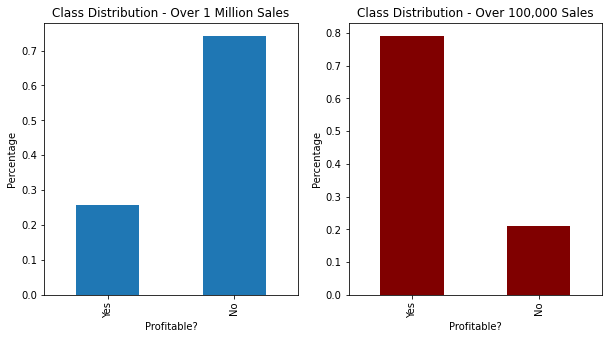

In [8]:
fig, ax = plt.subplots(ncols= 2, figsize = (10,5))

final_df['Over_1'].value_counts(normalize= True,ascending= True).plot(kind = 'bar', ax = ax[0])
ax[0].set_title('Class Distribution - Over 1 Million Sales');
ax[0].set_xlabel('Profitable?')
ax[0].set_xticklabels(['Yes', 'No'])
ax[0].set_ylabel('Percentage');

final_df['Over_.1'].value_counts(normalize= True).plot(kind = 'bar', ax = ax[1], color = 'maroon')
ax[1].set_title('Class Distribution - Over 100,000 Sales');
ax[1].set_xlabel('Profitable?')
ax[1].set_xticklabels(['Yes', 'No']);
ax[1].set_ylabel('Percentage');

Only **25.8%** of the games were able to make a sale of over 1 million. <br>
While the **74.2%** was unable to reach that benchmark. <br>
The benchmark differs from the size of the company. 

When considering most indie games consider sales over **100,000** sales to be successful, more games reached that benchmark. <br>
**79.1%** of games were considered profitable while only **20.9%** weren't able to. This makes sense since most games have to start as an indie developer before being a successful Triple-A title. 

### Rating Distribution Graph

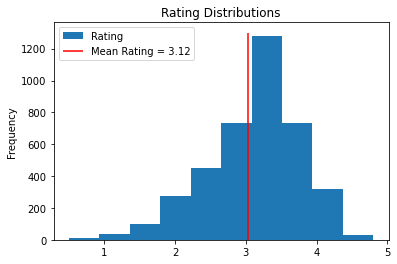

In [9]:
### Rating Distrbution 
final_df[final_df.Rating >= 0].Rating.plot(kind = 'hist', title = 'Rating Distributions', xlabel = 'Rating', sharex = False);
plt.vlines(df.Rating.mean(), 0, 1300, colors= 'red', label= 'Mean Rating = {}'.format(round(final_df.Rating.mean(), 2)));
plt.legend();

Normal distrbution of games would mean that all types of games were included leaving for a balanced dataset. <br>
If all or most of the **games perform well**, that would **indirectly lead** to **better sales** in most cases. 
Instead, since this website was built by the fanbase, there should be a balance of popular games and more obsure games.

### Genres Distribution Graph

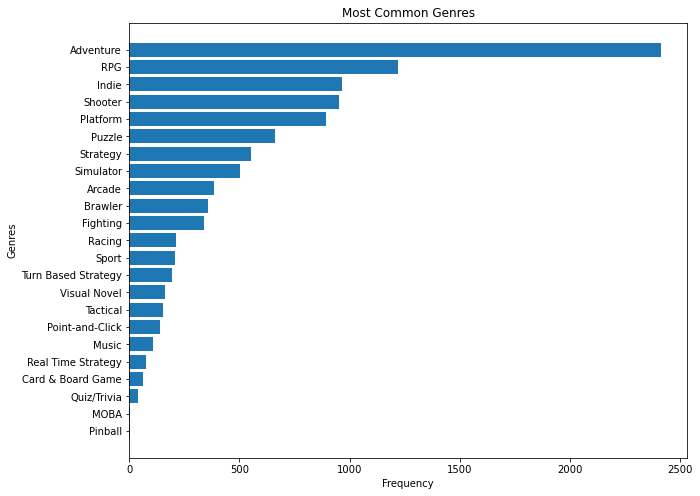

In [10]:
sort_genres = dc.count_values(final_df.Genres.values)
fig, ax = plt.subplots(figsize = (10,8))

ax.barh(list(sort_genres.keys()), list(sort_genres.values()));
ax.set_title('Most Common Genres');
ax.set_ylabel('Genres');
ax.set_xlabel('Frequency');

Unsurprisingly, **adventure** was the most common genre in the dataset having roughly **2500** with this tag, followed by **RGP, Indie, Shooter, and Platform**. <br>
Due to the number of games with these genres, we can expect that most of the profitable games would have **similar genres**.

In [11]:
genre_df = pd.concat([final_df.Title, pd.get_dummies(final_df['Genres'].explode(),drop_first= True).groupby(level=0).sum(), final_df[['Over_1']]], axis= 1)
genre_df_2 = pd.concat([final_df.Title, pd.get_dummies(final_df['Genres'].explode(),drop_first= True).groupby(level=0).sum(), final_df[['Over_.1']]], axis= 1)

## Baseline Models
The baseline model will be a Decision Tree with default parameters to have something to compare the different models and which performs the best. 
Two baseline models are made for the two conditions, the 100,000 unit threshold and the 1 million unit threshold. A random state of 10 was used on all the models to keep consistency. 

### Over 1 Million

In [12]:
X = genre_df[genre_df.columns[1:-1]]
y =  genre_df.Over_1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 10)
                                                            
baseline = DecisionTreeClassifier(random_state=10)  
baseline.fit(X_train, y_train) 

DecisionTreeClassifier(random_state=10)

### Over 100,000

In [13]:
X_2 = genre_df_2[genre_df.columns[1:-1]]
y_2 =  genre_df_2['Over_.1']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state= 10)
                                                            
baseline_2 = DecisionTreeClassifier(random_state=10)  
baseline_2.fit(X_train_2, y_train_2) 

DecisionTreeClassifier(random_state=10)

In [14]:
print('Accuracy (Over 1 M): {}%'.format(round(baseline.score(X_test, y_test),4) * 100))
print('Accuracy (Over 100,000): {}%'.format(round(baseline_2.score(X_test_2, y_test_2), 4) * 100))

Accuracy (Over 1 M): 72.52%
Accuracy (Over 100,000): 77.08%


### Baseline Model Anaysis
From the baseline models, there was a **72.52%** accuracy when determine whether a game would sell over 1 million units. <br>
There was a slight increase in the accuracy when determinng if a game would sell over 100,000 with **77.08%** accuracy.
It would be reasonable to assume that the model is more accurate when looking for games that sold more than 100,000 units since more games.

## Feature Importance Graphs
The model provides a feature importance for each feature giving a percentage to determine which was the most important when deciding the relevance of the genres. 
However, it is important to see the distribution of the genres alone to see if the data would favor one genre or another. Assuming that more games with a given genre would be picked out more often than a rare genre. 

In [15]:
feature_list = []
for name, value in zip(baseline.feature_names_in_, baseline.feature_importances_):
    feature_list.append((name, round(value*100, 2)))
feature_list = sorted(feature_list, key= lambda x: x[1])

feature_list_2 = []
for name, value in zip(baseline_2.feature_names_in_, baseline_2.feature_importances_):
    feature_list_2.append((name, round(value*100, 2)))
feature_list_2 = sorted(feature_list_2, key= lambda x: x[1])

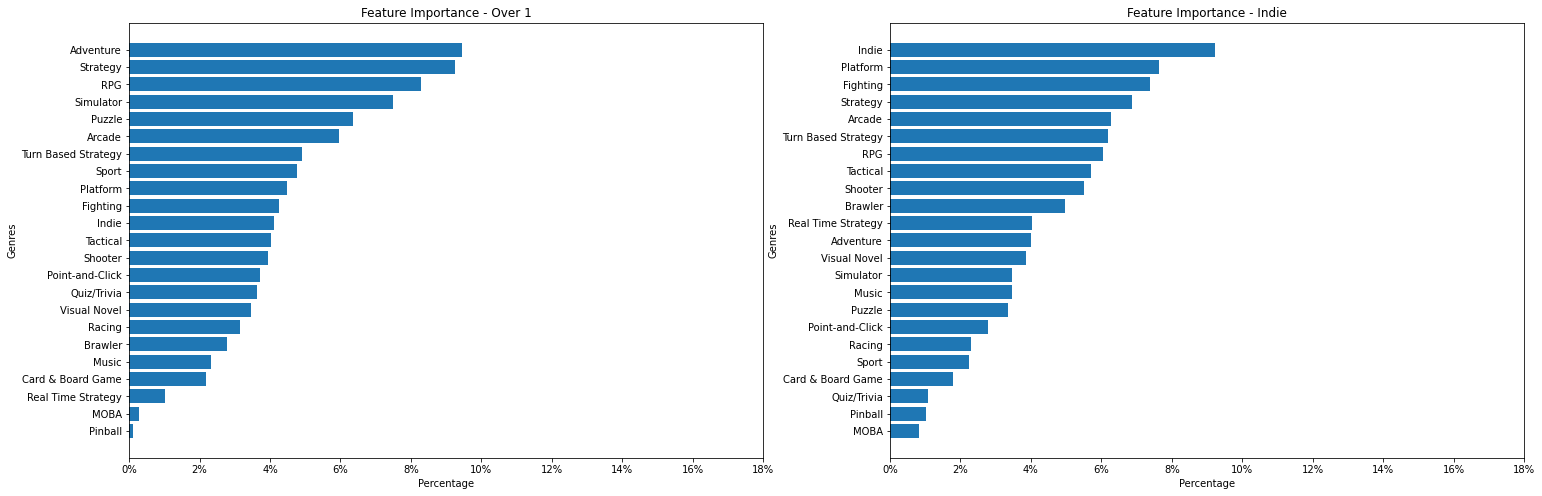

In [16]:
fig, ax = plt.subplots(ncols= 2,figsize = (25,8))

x_feat = [x[0] for x in feature_list]
y_feat = [x[1] for x in feature_list]

x_feat_2 = [x[0] for x in feature_list_2]
y_feat_2 = [x[1] for x in feature_list_2]

ax[0].barh(x_feat, y_feat)
ax[0].set_title('Feature Importance - Over 1')
xlabel = ['{}%'.format(x) for x in np.arange(0,20,2)]
ax[0].set_xticks(np.arange(0,20,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

ax[1].barh(x_feat_2, y_feat_2)
ax[1].set_title('Feature Importance - Indie')
xlabel = ['{}%'.format(x) for x in np.arange(0,20,2)]
ax[1].set_xticks(np.arange(0,20,2));
ax[1].set_xticklabels(xlabel);
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Percentage');

### Top Five Features Importance

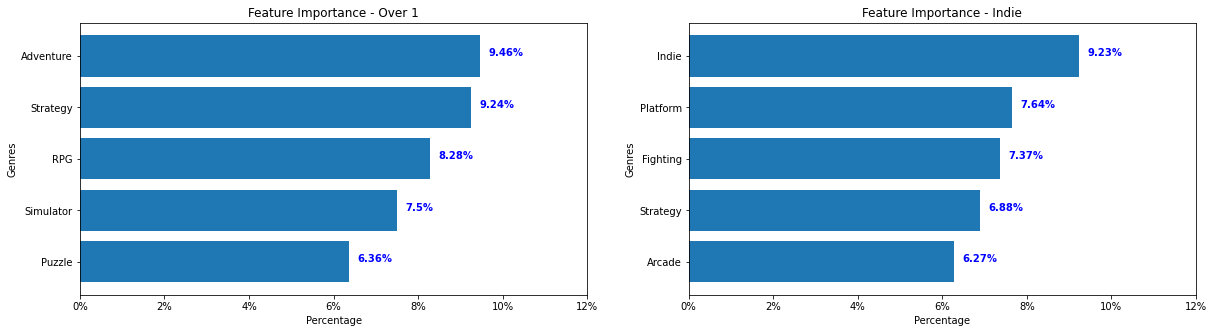

In [17]:
fig,ax = plt.subplots(ncols= 2, figsize = (20, 5))

x_feat = [x[0] for x in feature_list]
y_feat = [x[1] for x in feature_list]
xlabel = ['{}%'.format(x) for x in np.arange(0,14,2)]
ax[0].barh(x_feat[18:24], y_feat[18:24])
ax[0].set_title('Feature Importance - Over 1')

ax[0].set_xticks(np.arange(0,14,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

for i, v in enumerate(y_feat[18:24]):
    ax[0].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')
    

x_feat_2 = [x[0] for x in feature_list_2]
y_feat_2 = [x[1] for x in feature_list_2]    
ax[1].barh(x_feat_2[18:24], y_feat_2[18:24])
ax[1].set_title('Feature Importance - Indie')
ax[1].set_xticks(np.arange(0,14,2));
ax[1].set_xticklabels(xlabel);
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Percentage');

for i, v in enumerate(y_feat_2[18:24]):
    ax[1].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')

Interestingly, the difference between making a games that would make 1,000,000 units is completely different than that of of 100,000. The only similar genre that the top 5 genres was strategy with adventure and indie games being the most importance for 1 million and 100,000 respectively. 

Looking back with most common genres, **most of those genres** appear to be in **one of the two feature importance list** with shooter being in neigher. 
This directly support the fact that even though many gaves have the title, **they are not directly correctate to a good selling games**. In other words, **some genres would work better** for **indie** games than others. 

## Random Forest Model

In [18]:
random = RandomForestClassifier(random_state=10)  
random_2 = RandomForestClassifier(random_state=10)  

random.fit(X_train, y_train) 
random_2.fit(X_train_2, y_train_2) 

random_list = []
for name, value in zip(random.feature_names_in_, random.feature_importances_):
    random_list.append((name, round(value*100, 2)))
random_list = sorted(random_list, key= lambda x: x[1])

random_list_2 = []
for name, value in zip(random_2.feature_names_in_, random_2.feature_importances_):
    random_list_2.append((name, round(value*100, 2)))
random_list_2 = sorted(random_list_2, key= lambda x: x[1])

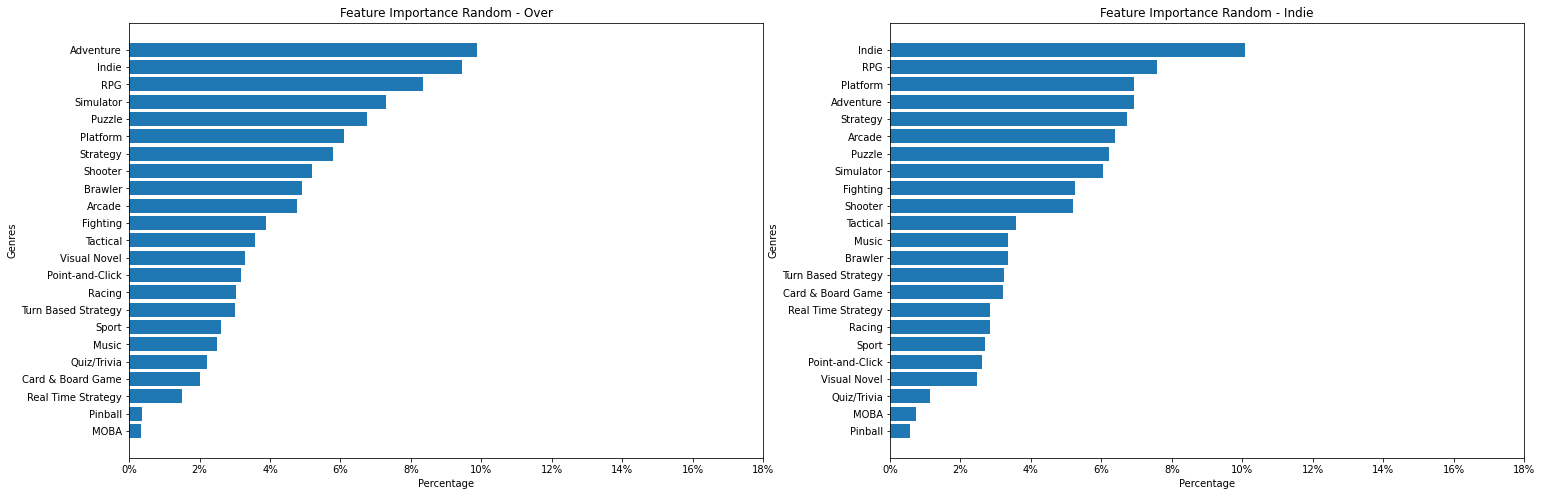

In [19]:
fig, ax = plt.subplots(ncols= 2,figsize = (25,8))

x_feat = [x[0] for x in random_list]
y_feat = [x[1] for x in random_list]
ax[0].barh(x_feat, y_feat)
ax[0].set_title('Feature Importance Random - Over')
xlabel = ['{}%'.format(x) for x in np.arange(0,20,2)]
ax[0].set_xticks(np.arange(0,20,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

x_feat_2 = [x[0] for x in random_list_2]
y_feat_2 = [x[1] for x in random_list_2]
ax[1].barh(x_feat_2, y_feat_2)
ax[1].set_title('Feature Importance Random - Indie')
xlabel = ['{}%'.format(x) for x in np.arange(0,20,2)]
ax[1].set_xticks(np.arange(0,20,2));
ax[1].set_xticklabels(xlabel);
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Percentage');

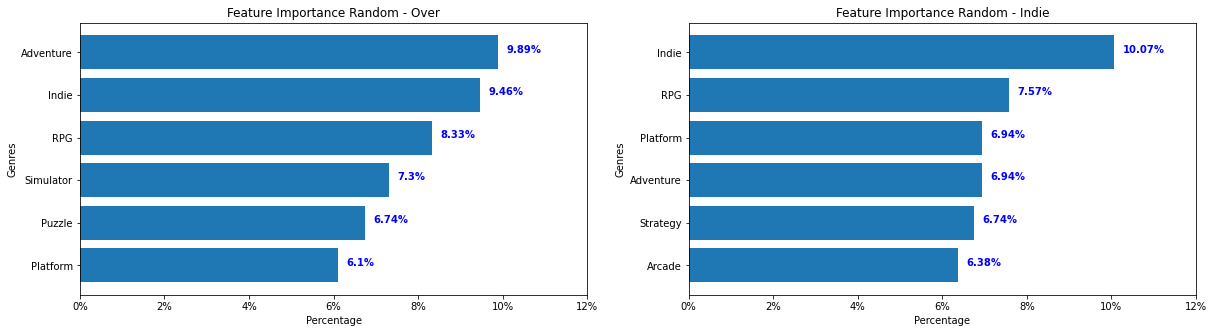

In [20]:
fig,ax = plt.subplots(ncols= 2, figsize = (20, 5))

x_feat = [x[0] for x in random_list]
y_feat = [x[1] for x in random_list]
xlabel = ['{}%'.format(x) for x in np.arange(0,14,2)]
ax[0].barh(x_feat[17:24], y_feat[17:24])
ax[0].set_title('Feature Importance Random - Over')

ax[0].set_xticks(np.arange(0,14,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

for i, v in enumerate(y_feat[17:24]):
    ax[0].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')
    

x_feat_2 = [x[0] for x in random_list_2]
y_feat_2 = [x[1] for x in random_list_2]    
ax[1].barh(x_feat_2[17:24], y_feat_2[17:24])
ax[1].set_title('Feature Importance Random - Indie')
ax[1].set_xticks(np.arange(0,14,2));
ax[1].set_xticklabels(xlabel);
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Percentage');

for i, v in enumerate(y_feat_2[17:24]):
    ax[1].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')

In [21]:
print('Random Forest Accuracy Results')
print('Over 1 million Threshold: {}%'.format(round(random.score(X_test, y_test), 4)*100))
print('Over 100,00 Threshold: {}%'.format(round(random_2.score(X_test_2, y_test_2), 4)* 100))

Random Forest Accuracy Results
Over 1 million Threshold: 73.14%
Over 100,00 Threshold: 77.89%


In [22]:
# Original Parameter Grid 

# param_grid = {
#                 'n_estimators' : [10, 20, 50, 75, 100],
#                 'criterion': ['entropy'],
#                 'max_depth' : [None, 10, 15, 20, 25, 30],
#                 'min_samples_split' : [.1, .3,.5, .7, .9, 2, 4, 6, 10],
#                 'min_samples_leaf' : [.1, .3,.5, .7, .9, 2, 4, 6, 10],
#                 'max_features' : [None, 'sqrt', 10, 15, 20],
#                 'random_state': [10]
#              }

In [23]:
# {'criterion': 'entropy',
#  'max_depth': None,
#  'max_features': None,
#  'min_samples_leaf': 6,
#  'min_samples_split': 0.1,
#  'n_estimators': 20,
#  'random_state': 10}

forest_clf_base = RandomForestClassifier()
forest_grid_search = GridSearchCV(forest_clf_base, param_grid, return_train_score= True, cv= 3, scoring= 'accuracy')
forest_grid_search.fit(X_train, y_train)

NameError: name 'param_grid' is not defined

In [24]:
indie_genre = genre_df.loc[genre_df.Indie == 1]
indie_genre_2 = genre_df_2.loc[genre_df_2.Indie == 1]



### Indie Tag Over 1 Million

In [25]:
X_3 = indie_genre[indie_genre.columns[1:-1]]
y_3 =  indie_genre['Over_1']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, random_state= 10)
model_indie_over = RandomForestClassifier(criterion = 'entropy',max_depth = 15, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 10, random_state = 10)
model_indie_over.fit(X_train_3, y_train_3)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       n_estimators=10, random_state=10)

### Indie Tag Over 100,000

In [26]:
X_4 = indie_genre_2[indie_genre_2.columns[1:-1]]
y_4 =  indie_genre_2['Over_.1']
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, random_state= 10)
model_indie = RandomForestClassifier(criterion = 'entropy',max_depth = None, max_features = 10, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 10, random_state = 10)
model_indie.fit(X_train_4, y_train_4)

RandomForestClassifier(criterion='entropy', max_features=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=10, random_state=10)

In [27]:
random_list_3 = []
for name, value in zip(model_indie_over.feature_names_in_, model_indie_over.feature_importances_):
    random_list_3.append((name, round(value*100, 2)))
random_list_3 = sorted(random_list_3, key= lambda x: x[1])

random_list_4 = []
for name, value in zip(model_indie.feature_names_in_, model_indie.feature_importances_):
    random_list_4.append((name, round(value*100, 2)))
random_list_4 = sorted(random_list_4, key= lambda x: x[1])

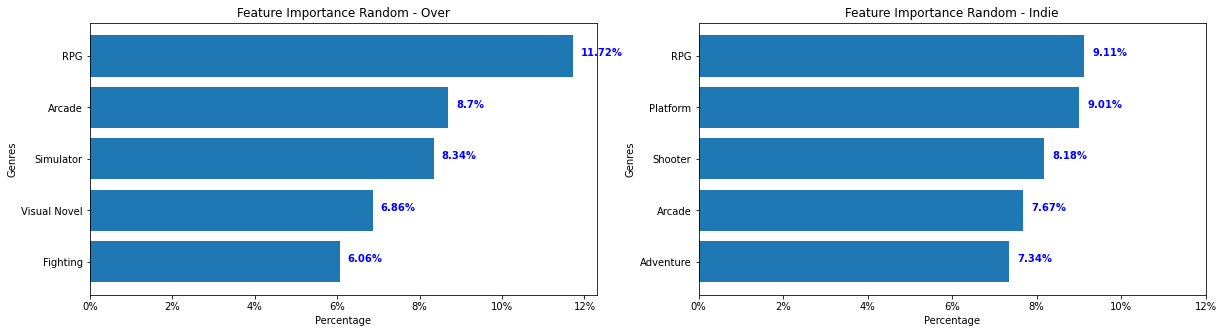

In [28]:
fig,ax = plt.subplots(ncols= 2, figsize = (20, 5))

x_feat = [x[0] for x in random_list_3]
y_feat = [x[1] for x in random_list_3]
xlabel = ['{}%'.format(x) for x in np.arange(0,14,2)]
ax[0].barh(x_feat[18:24], y_feat[18:24])
ax[0].set_title('Feature Importance Random - Over')

ax[0].set_xticks(np.arange(0,14,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

for i, v in enumerate(y_feat[18:24]):
    ax[0].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')
    

x_feat_2 = [x[0] for x in random_list_4]
y_feat_2 = [x[1] for x in random_list_4]    
ax[1].barh(x_feat_2[18:24], y_feat_2[18:24])
ax[1].set_title('Feature Importance Random - Indie')
ax[1].set_xticks(np.arange(0,14,2));
ax[1].set_xticklabels(xlabel);
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Percentage');

for i, v in enumerate(y_feat_2[18:24]):
    ax[1].text(v + .2, i, str(v) + '%', color='blue', fontweight='bold')

In [29]:
print(random.score(X_test, y_test))    ### Over 1 Default Random
print(forest_grid_search.score(X_test, y_test))   ### Over 1 Gridsearch Random
print(model_indie_over.score(X_test_3, y_test_3))   ### Over 1 Gridsearch Indie
print(model_indie.score(X_test_4, y_test_4))   ### Over .1 Gridseach Indie

0.7314234556848702


NameError: name 'forest_grid_search' is not defined

### Random Forest Results
| Modeling Attempt | Accuracy | Note |
|:---:|:---:|:---:|
| 1 | .7314 | Default Parameters  |
| 2 | .7466 | Regular Gridsearch |
| 3 | **.7520** | Indie Title Over 1 |
| 4 | **.7520** | Indie Title Over .1 |

## Results Summary
When looking over video games that made over 1 million in sales, the best genres to have adventure, rpg, simulartor and stratgery games. Since there is a satruatration of Adventure and RPG, stratgety and simulator games would be best to make games that people would buy. This may be due to that most games pair these genres togther so it woud best to avoid these genres unless known for the genre themselves. Keep in mind that less games may also mean that most audience may not be looking for that specific genre at all which may limit others to play. The desireable result would being able to make game that encompass multiple genres like adding stragery in their adventure games or shooter platformer. 

WHen looking at the idea of indie developers in mind, there is a slight change in mindset. Indie games have two choice in making a game, make a unique game and define the genre they planned with their game, or go to a niche area that have little to no competition to the genre instead. There seems to be a great deal of interest in indie gmaes as a whole, being consistiently the most important genre in making over 100,000 in sales. If the goal is to start making games, it would be safe to stick with the games in the top feature importance to increase the chances of a good game. Once a genre of games proves to be the best, the best advice would be to conitune to make the games to define themsleves to that genre. Most opeople won't expect anything so stikcing with the common titles would be safest. 

When looking at feature importance when looking at the games labeled with Indie, there was a drascic shift in what the model determine as important. It appeared that RPG and Arcade performed the best for both the threshhols meaning that the most successful indie games were with these genres. Other good genres were variety with platformer, simulator, visual novel, adventure, and fighting. Given how Indie games usually varies, sticking the RPG's and Arcade style games would be best for new developers


| Threshhold | Over 1,000,000 | Over 100,000 |
|:---:|:---:|:---:|
| 1 | Adventure | RPG |
| 2 | RPG | Platform |
| 3 | **Simulator** | Adventure |
| 4 | **Puzzle** | **Strategy** |
| 5 | Platform | **Arcade** |

**Triple-A Developer**: <br>
**Safe genres** to make are **Adventure and RPG** due to the reliablity in the gaming market. <br>
Add **puzzle and simulators** for added varity in games to increase performance.

**Indie Developers**: <br>
Avoid uncommon genres and stick to the common genres. **Adventure and RPG** are safe as well along with **platformer and shooters**. 
Adding **Strategy or Acade** in their game would increase the likelihood of performing well. 

More Analysis
A balance of making a game that is both deisrable and popular with the audience can determine what sytle of games to make. Using the rest of the dataset, I gauge on what most users want to play and rate higher on average. This could prove more useful to Triple-A titles as they would have more resource compare to the smaller develiper.

In [67]:
ranked_genres = pd.DataFrame(zip(sort_genres.keys(),[name[0] for name in random_list], [name[0] for name in random_list_2]), columns=['Most Common', 'Triple-A', 'Indie'], )

In [68]:
ranked_genres.sort_values('Most Common', inplace= True)
first_list = ranked_genres.index

In [70]:
ranked_genres.sort_values('Triple-A', inplace= True)
second_list = ranked_genres.index

In [71]:
ranked_genres.sort_values('Indie', inplace= True)
third_list = ranked_genres.index

In [75]:
Tripe_list = zip(ranked_genres.Indie,[x + y for x,y in zip(first_list, second_list)])
Tripe_list = sorted(Tripe_list, key= lambda x: x[1])
for name, rank in Tripe_list:
    print(name, rank)

MOBA 1
Pinball 1
Card & Board Game 6
Quiz/Trivia 6
Real Time Strategy 6
Music 10
Point-and-Click 15
Sport 16
Turn Based Strategy 16
Tactical 18
Visual Novel 18
Racing 19
Fighting 24
Arcade 27
Brawler 27
Strategy 32
Shooter 34
Simulator 34
Platform 35
Puzzle 35
Indie 41
RPG 41
Adventure 44


In [64]:
Indie_list = zip(ranked_genres.Indie,[x + y for x,y in zip(first_list, third_list)])